In [1]:
import IPython.display as ipd
import torch
import matplotlib.pyplot as plt
import scipy.io
import numpy as np
import torch.nn.functional as F
import librosa.output
from matplotlib import cm
import matplotlib

/homes/grail/vjayaram/.local/lib/python3.6/site-packages/pkg_resources/__init__.py:1908: UserWarning: /homes/grail/vjayaram/.local/lib/python3.6/site-packages/._wrapt-1.11.2-py3.6.egg-info could not be properly decoded in UTF-8
  warnings.warn(msg)
/homes/grail/vjayaram/.local/lib/python3.6/site-packages/pkg_resources/__init__.py:1908: UserWarning: /homes/grail/vjayaram/.local/lib/python3.6/site-packages/._termcolor-1.1.0-py3.6.egg-info could not be properly decoded in UTF-8
  warnings.warn(msg)
/homes/grail/vjayaram/.local/lib/python3.6/site-packages/pkg_resources/__init__.py:1908: UserWarning: /homes/grail/vjayaram/.local/lib/python3.6/site-packages/._librosa-0.7.0-py3.6.egg-info could not be properly decoded in UTF-8
  warnings.warn(msg)
/homes/grail/vjayaram/.local/lib/python3.6/site-packages/pkg_resources/__init__.py:1908: UserWarning: /homes/grail/vjayaram/.local/lib/python3.6/site-packages/._audioread-2.1.8-py3.6.egg-info could not be properly decoded in UTF-8
  warnings.warn(ms

In [2]:
matplotlib.style.use('ggplot')

In [3]:
from data import SpatialAudioDatasetWaveform
from network import center_trim, Demucs

In [5]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [6]:
test_dir = '/projects/grail/audiovisual/datasets/DinTaiFung/1_voice_1_bg_varying_angle/test'
data_test = SpatialAudioDatasetWaveform(test_dir, n_sources=1, n_backgrounds=1)
device = torch.device('cuda:0')

In [7]:
kwargs = {
    'num_workers': 4,
    'pin_memory': True
}

In [8]:
import torch
print(torch.rand(1, device="cuda"))

tensor([0.4130], device='cuda:0')


In [9]:
test_loader = torch.utils.data.DataLoader(data_test,
                                          batch_size=32,
                                          **kwargs)

In [10]:
%ls checkpoints/2_mics_varying_voice_angle*

checkpoints/2_mics_varying_voice_angle_0.pt
checkpoints/2_mics_varying_voice_angle_100.pt
checkpoints/2_mics_varying_voice_angle_101.pt
checkpoints/2_mics_varying_voice_angle_102.pt
checkpoints/2_mics_varying_voice_angle_103.pt
checkpoints/2_mics_varying_voice_angle_104.pt
checkpoints/2_mics_varying_voice_angle_105.pt
checkpoints/2_mics_varying_voice_angle_106.pt
checkpoints/2_mics_varying_voice_angle_107.pt
checkpoints/2_mics_varying_voice_angle_108.pt
checkpoints/2_mics_varying_voice_angle_109.pt
checkpoints/2_mics_varying_voice_angle_10.pt
checkpoints/2_mics_varying_voice_angle_110.pt
checkpoints/2_mics_varying_voice_angle_111.pt
checkpoints/2_mics_varying_voice_angle_112.pt
checkpoints/2_mics_varying_voice_angle_113.pt
checkpoints/2_mics_varying_voice_angle_114.pt
checkpoints/2_mics_varying_voice_angle_115.pt
checkpoints/2_mics_varying_voice_angle_116.pt
checkpoints/2_mics_varying_voice_angle_117.pt
checkpoints/2_mics_varying_voice_angle_118.pt
checkpoints/2_mics_varying_voice_angl

In [11]:
model = Demucs(sources=2, n_audio_channels=2)

In [12]:
# model.load_state_dict(torch.load('checkpoints/mics8_radius3_demucs_nospatial_47.pt'))
# model.load_state_dict(torch.load('checkpoints/mics8_radius3_demucs_nospatial_10.pt').module.state_dict())
# model.load_state_dict(torch.load('checkpoints/shifted_input_nchannels_169.pt'))
model.load_state_dict(torch.load('checkpoints/2_mics_varying_voice_angle_200.pt'))
model.train = False
model.to(device)

Demucs(
  (encoder): ModuleList(
    (0): Sequential(
      (0): Conv1d(2, 64, kernel_size=(8,), stride=(4,))
      (1): ReLU()
      (2): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
      (3): GLU(dim=1)
    )
    (1): Sequential(
      (0): Conv1d(64, 128, kernel_size=(8,), stride=(4,))
      (1): ReLU()
      (2): Conv1d(128, 256, kernel_size=(1,), stride=(1,))
      (3): GLU(dim=1)
    )
    (2): Sequential(
      (0): Conv1d(128, 256, kernel_size=(8,), stride=(4,))
      (1): ReLU()
      (2): Conv1d(256, 512, kernel_size=(1,), stride=(1,))
      (3): GLU(dim=1)
    )
    (3): Sequential(
      (0): Conv1d(256, 512, kernel_size=(8,), stride=(4,))
      (1): ReLU()
      (2): Conv1d(512, 1024, kernel_size=(1,), stride=(1,))
      (3): GLU(dim=1)
    )
    (4): Sequential(
      (0): Conv1d(512, 1024, kernel_size=(8,), stride=(4,))
      (1): ReLU()
      (2): Conv1d(1024, 2048, kernel_size=(1,), stride=(1,))
      (3): GLU(dim=1)
    )
    (5): Sequential(
      (0): Conv1d(1024

In [14]:
with torch.no_grad():
    for batch_idx, (data, label_voice_signals, label_bg_signals, label_voice_locs, label_bg_locs) in enumerate(test_loader):
        print(batch_idx)
        if batch_idx != 0: continue
#         data = label_bg_signals[:,0,:,:]
        data = data.to(device)
        label_voice_signals = label_voice_signals.to(device)

        # Normalize input
        data_transformed = (data * 2**15).round() / 2**15
        ref = data_transformed.mean(0)
        data_transformed = (data_transformed - ref.mean()) / ref.std()

        # Run through the model
        valid_length = model.valid_length(data_transformed.shape[-1])
        delta = valid_length - data_transformed.shape[-1]
        padded = F.pad(data_transformed, (delta // 2, delta - delta // 2))

        output_signal, output_locs = model(padded)
        output_signal = center_trim(output_signal, data_transformed)
        output_locs = center_trim(output_locs, data_transformed)
        
        output_signal = output_signal * ref.std() + ref.mean()
        output_voices = output_voices = output_signal[:, 0:1]

        break

0


In [15]:
output_voices.shape

torch.Size([32, 1, 2, 66150])

In [90]:
for i in range(32):
    print("idx {} loss {}".format(i, model.voice_loss(output_voices[i], label_voice_signals[i])[0]))
idx = 7

idx 0 loss 0.004987156484276056
idx 1 loss 0.0016893635038286448
idx 2 loss 0.0018941467860713601
idx 3 loss 0.004094928037375212
idx 4 loss 0.0073218862526118755
idx 5 loss 0.004752054810523987
idx 6 loss 0.03486631065607071
idx 7 loss 0.009901538491249084
idx 8 loss 0.005824143532663584
idx 9 loss 0.010000699199736118
idx 10 loss 0.0031413151882588863
idx 11 loss 0.015821898356080055
idx 12 loss 0.007297604810446501
idx 13 loss 0.006429663393646479
idx 14 loss 0.004504450596868992
idx 15 loss 0.005245328415185213
idx 16 loss 0.0024892217479646206
idx 17 loss 0.005346566438674927
idx 18 loss 0.0034631199669092894
idx 19 loss 0.004607710521668196
idx 20 loss 0.006102250423282385
idx 21 loss 0.0019442986231297255
idx 22 loss 0.018129246309399605
idx 23 loss 0.0065896413289010525
idx 24 loss 0.005785185378044844
idx 25 loss 0.008934784680604935
idx 26 loss 0.0035030515864491463
idx 27 loss 0.004203958436846733
idx 28 loss 0.003134289523586631
idx 29 loss 0.00584608968347311
idx 30 loss 0

In [91]:
label_voice_signals.shape

torch.Size([32, 1, 2, 66150])

In [92]:
label_bg_signals.shape

torch.Size([32, 1, 2, 66150])

In [93]:
data.shape

torch.Size([32, 2, 66150])

In [94]:
inputs = data[idx,:,:].cpu().detach().numpy()

In [95]:
v_min = 1.5*np.min(inputs)
v_max = 1.5*np.max(inputs)

[]

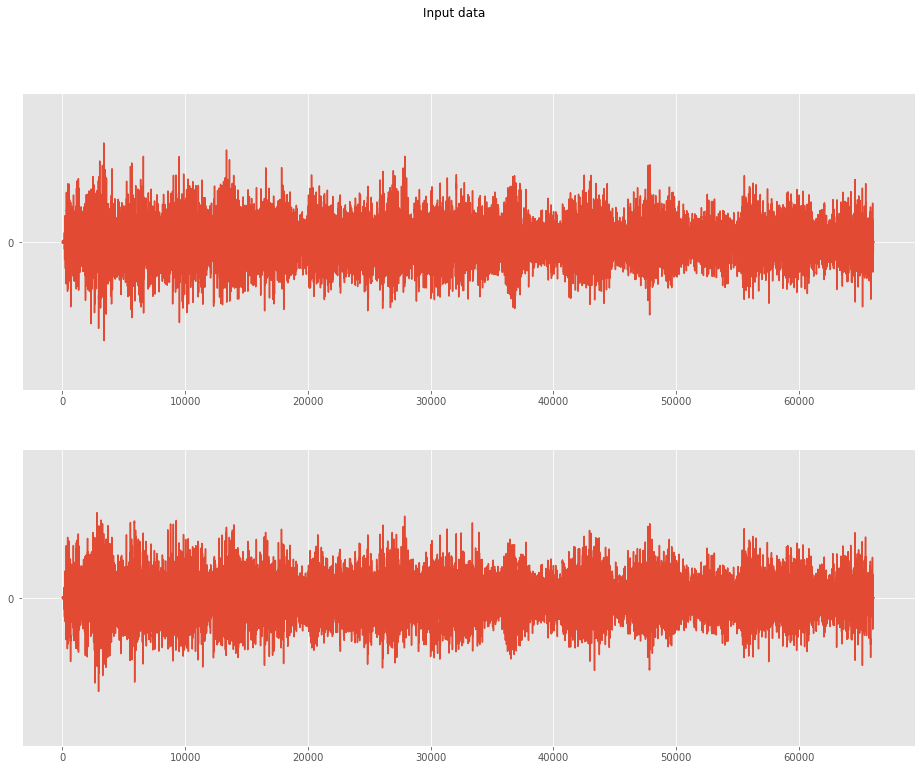

In [96]:
plt.figure(figsize=(16, 12))
for i in range(inputs.shape[0]):
    plt.subplot(inputs.shape[0], 1, i+1)
    plt.plot(inputs[i])
    plt.ylim([v_min, v_max])
    plt.yscale('symlog')
plt.suptitle("Input data")    
plt.plot()

In [97]:
label_voices = label_voice_signals[idx,0,:,:].cpu().detach().numpy()

[]

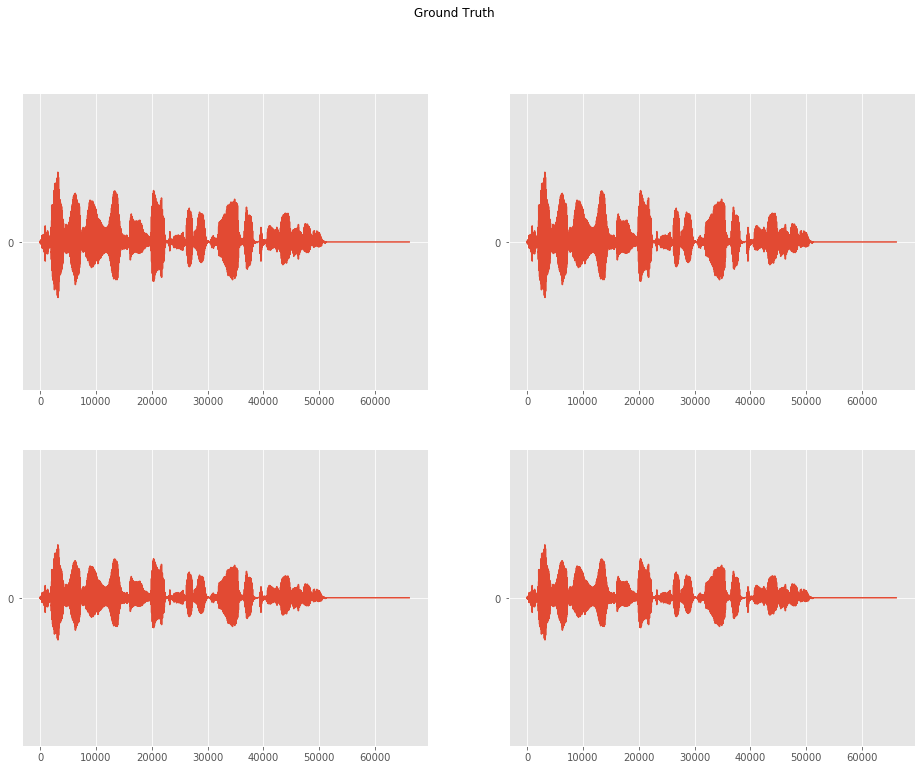

In [98]:
plt.figure(figsize=(16, 12))
for i in range(label_voices.shape[0]):
    plt.subplot(label_voices.shape[0], 2, 2*i+1)
    plt.plot(label_voices[i])
    plt.ylim([v_min, v_max])
    plt.yscale('symlog')
    plt.subplot(label_voices.shape[0], 2, 2*i+2)
    plt.plot(label_voices[i])
    plt.ylim([v_min, v_max])
    plt.yscale('symlog')
plt.suptitle("Ground Truth")    
plt.plot()

In [99]:
np.max(label_voices)

0.6759033

In [100]:
output_voice_signals = output_voices[idx,0,:,:].cpu().detach().numpy()

[]

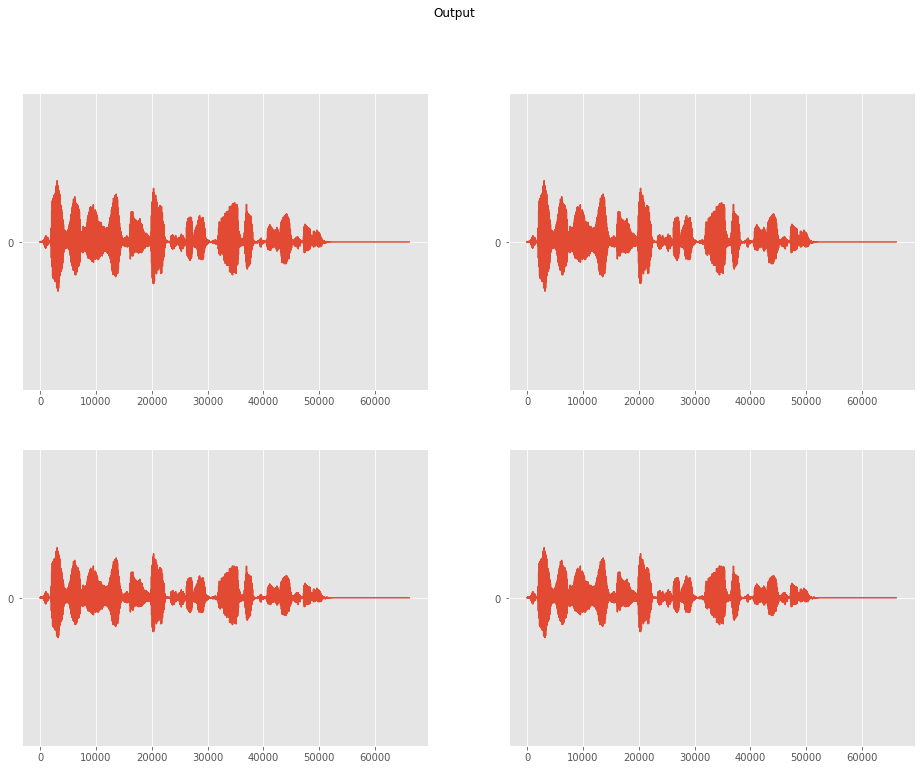

In [101]:
plt.figure(figsize=(16, 12))
for i in range(output_voice_signals.shape[0]):
    plt.subplot(output_voice_signals.shape[0], 2, 2*i+1)
    plt.plot(output_voice_signals[i])
    plt.ylim([v_min, v_max])
    plt.yscale('symlog')
    plt.subplot(output_voice_signals.shape[0], 2, 2*i+2)
    plt.plot(output_voice_signals[i])
    plt.ylim([v_min, v_max])
    plt.yscale('symlog')
plt.suptitle("Output")
plt.plot()

In [102]:
ipd.Audio(data=(inputs[0]), rate=22050, normalize=False)

In [103]:
ipd.Audio(data=(label_voices[0]), rate=22050, normalize=False)

In [104]:
np.min(output_voice_signals[0])

-0.4773094

In [105]:
np.min(label_voices[0])

-0.5379944

In [106]:
ipd.Audio(data=output_voice_signals, rate=22050, normalize=False)

In [ ]:
ipd.Audio(data=(output_bg_signals[0]), rate=22050, normalize=True)

In [ ]:
from librosa.core import stft, istft
from librosa.display import specshow

In [ ]:
y = output_voice_signals[0]

In [ ]:
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=1.0)
plt.figure(figsize=(16, 8), dpi=300)
plt.subplot(1, 2, 1)
librosa.display.specshow(D, y_axis='linear', cmap=cm.jet)
plt.colorbar(format='%+2.0f dB')
plt.title('Linear-frequency power spectrogram')
plt.subplot(1, 2, 2)
librosa.display.specshow(D, y_axis='log', cmap=cm.jet)
plt.colorbar(format='%+2.0f dB')
plt.title('Log-frequency power spectrogram')
plt.plot()

In [ ]:
# D = np.clip(D, -20, 0)

In [ ]:
plt.figure(figsize=(8,6), dpi=300)
counts, bins = np.histogram(D, bins=30)
plt.hist(bins[:-1], bins, weights=counts)
plt.ylim([1, 1e5])
plt.yscale('log')
plt.ylabel('count')
plt.xlabel('dB')
plt.title('Histogram')
plt.plot()

In [ ]:
Y = stft(y)
plt.plot(np.sum(np.abs(Y), axis=1))

In [ ]:
Y[:2, :] = 0
plt.plot(np.sum(np.abs(Y), axis=1))

In [ ]:
Y[np.where(np.sum(np.abs(Y), axis=1) >= 10), :] = 0
plt.plot(np.sum(np.abs(Y), axis=1))

In [ ]:
# Y = librosa.util.normalize(Y)

In [ ]:
plt.plot(istft(Y))

In [ ]:
D = librosa.amplitude_to_db(np.abs(Y), ref=1.0)
librosa.display.specshow(D, y_axis='log', cmap=cm.jet)
plt.colorbar(format='%+2.0f dB')
plt.title('Log-frequency power spectrogram')

In [ ]:
newy = istft(Y)

In [ ]:
D = librosa.amplitude_to_db(np.abs(librosa.stft(newy)), ref=1.0)
plt.figure(figsize=(16, 8), dpi=300)
plt.subplot(1, 2, 1)
librosa.display.specshow(D, y_axis='linear', cmap=cm.jet)
plt.colorbar(format='%+2.0f dB')
plt.title('Linear-frequency power spectrogram')
plt.subplot(1, 2, 2)
librosa.display.specshow(D, y_axis='log', cmap=cm.jet)
plt.colorbar(format='%+2.0f dB')
plt.title('Log-frequency power spectrogram')
plt.plot()

In [ ]:
plt.figure(figsize=(8,6), dpi=300)
counts, bins = np.histogram(D, bins=30)
plt.hist(bins[:-1], bins, weights=counts)
plt.ylim([1, 1e5])
plt.yscale('log')
plt.ylabel('count')
plt.xlabel('dB')
plt.title('Histogram')
plt.plot()

In [ ]:
y_gt = label_voices[0]
D = librosa.amplitude_to_db(np.abs(librosa.stft(y_gt)), ref=1.0)
plt.figure(figsize=(16, 8), dpi=300)
plt.subplot(1, 2, 1)
librosa.display.specshow(D, y_axis='linear', cmap=cm.jet)
plt.colorbar(format='%+2.0f dB')
plt.title('Linear-frequency power spectrogram')
plt.subplot(1, 2, 2)
librosa.display.specshow(D, y_axis='log', cmap=cm.jet)
plt.colorbar(format='%+2.0f dB')
plt.title('Log-frequency power spectrogram')
plt.plot()

In [ ]:
plt.figure(figsize=(8,6), dpi=300)
counts, bins = np.histogram(D, bins=30)
plt.hist(bins[:-1], bins, weights=counts)
plt.ylim([1, 1e5])
plt.yscale('log')
plt.ylabel('count')
plt.xlabel('dB')
plt.title('Histogram')
plt.plot()

In [ ]:
x = data[0][1].cpu().numpy()

In [ ]:
ipd.Audio(data=(newy), rate=22050)

In [ ]:
ipd.Audio(data=(labels[3]), rate=22050)

In [ ]:
ipd.Audio(data=(newy), rate=22050)

In [ ]:
top = np.sum(librosa.util.normalize(outputs[0]) ** 2) / outputs[0].shape[0]
bottom = np.sum(librosa.util.normalize(labels[0]) ** 2) / labels[0].shape[0]

In [ ]:
SDR = 10 * np.log10(top / bottom)

In [ ]:
print(SDR)

In [ ]:
binaural = False
if outputs.shape[0] == 2:
    binaural = True

In [ ]:
import os
base_dir = 'jan24'
os.makedirs(base_dir, exist_ok=True)

In [ ]:
if not binaural:
    for i in range(outputs.shape[0]):
        librosa.output.write_wav('{}/input_{}.wav'.format(base_dir, i), inputs[i], sr=22050)
        librosa.output.write_wav('{}/output_{}.wav'.format(base_dir, i), 100 * outputs[i], sr=22050)
        librosa.output.write_wav('{}/label_{}.wav'.format(base_dir, i), labels[i], sr=22050)
else:
    librosa.output.write_wav('{}/input.wav'.format(base_dir, i), np.asfortranarray(np.vstack(inputs)), sr=22050)
    librosa.output.write_wav('{}/output.wav'.format(base_dir, i), np.asfortranarray(np.vstack(outputs)), sr=22050)
    librosa.output.write_wav('{}/label.wav'.format(base_dir, i), np.asfortranarray(np.vstack(labels)), sr=22050)
        

233 => 1.121
150 => 1.835
100 => 1.036
50 => 0.648